In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import round
from pyspark.sql import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import log
from pyspark.sql.functions import regexp_replace
import matplotlib.pyplot as plt  
import scipy.stats as st
import seaborn as sns
import pandas as pd
from operator import add
from functools import reduce

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/14 13:32:01 WARN Utils: Your hostname, Zhangs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.12.6.181 instead (on interface en0)
22/10/14 13:32:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/14 13:32:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/14 13:32:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Read processed Dataframe for ranking
final = spark.read.parquet('../data/curated/merchant_info.parquet')
final_pd = final.toPandas()

In [3]:
# Select all the numeric features
col_list_1 = final.columns

del_col_list = ['Store_type', 'Revenue_levels', 'merchant_abn','postcode']

for i in del_col_list:
    col_list_1.remove(i)

In [4]:
final.limit(3)

Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,postcode,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,merchant_abn,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value
shoe shops,b,5088.108,0,1169.68,3.28,356.85,1660,16.41769282602561,0.0,3.28,42330360779,0,0.3924226684563543,0.5395286144327325,391.16650390625
"opticians, optica...",a,8020.69,0,1289.5,21.56,59.82,1660,15.594208059208613,0.0,21.28,73221370757,0,0.3924226684563543,0.5395286144327325,115.49871063232422
art dealers and g...,c,5908.3479,0,3126.11,2.44,1278.86,2482,14.965341864244008,0.0,2.44,97598804219,0,0.19071467244179752,0.5701438848920863,927.2828369140625


In [5]:
# Input origginal dataframe, return new dataframe that mapping numeric and ordinal data to 0-100 
# in order to make all the features in same scale for calculating the score
def get_map_df(unsort_df, col_list_1):
    max_list = []
    min_list = []
    # Calculate max and min value in each numeric features
    for i in col_list_1:
        max_num = float(final.agg({i: "max"}).collect()[0][0])
        min_num = float(final.agg({i: "min"}).collect()[0][0])
        max_list.append(max_num)
        min_list.append(min_num)
    # Map each feature to 0-100
    for i in range(0,12):
        unsort_df = unsort_df.withColumn(col_list_1[i], (col(col_list_1[i]) - min_list[i])*100/(max_list[i]-min_list[i]))
    # Times -1 to fraud features because for fraud less is better
    unsort_df = unsort_df.withColumn('avg_prob_fraud_cus', (unsort_df.avg_prob_fraud_cus *(-1))) \
        .withColumn('prob_of_fraud', (unsort_df.prob_of_fraud*(-1)))
    unsort_df = unsort_df.select('merchant_abn','Store_type', 'Revenue_levels', 'Take_rate', \
        'count_of_bigorder', 'Avg_amount_monthly', 'Avg_count_monthly', 'Order_avg_value',	\
        'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon', 'fix_cus_num', \
        'avg_income_percentage', 'avg_age_percentage','predict_dollar_value')
    # Assign a value to the each revenue level, also in the range 0-100
    reve_list = ['a', 'b', 'c', 'd', 'e']
    reve_num = [0, 25, 50, 75, 100]
    for i in range(len(reve_list)):
        unsort_df = unsort_df.withColumn('Revenue_levels', when(col('Revenue_levels') == reve_list[i], reve_num[i]).otherwise(col('Revenue_levels')))
    return unsort_df

In [6]:
# final_1 is the dataframe after mapping
final_1 = get_map_df(final, col_list_1)

### Baseline Model

In [7]:
# purely add all the scores together without weighting as baseline
pure_add = final_1.withColumn('pure_add_score',reduce(add, [F.col(x) for x in final_1.columns[2:15]]))
pure_add_rank = pure_add.sort(pure_add.pure_add_score.desc())

In [8]:
pure_add_rank

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,pure_add_score
24852446429,florists supplies...,50,31.6241113540929,0.0,64.92189809702175,96.6141888009075,0.036050652902386016,-8.51575702950217,-0.4074534161490683,99.98569077770622,99.15389774544704,52.02931741035037,67.15831110113018,5.704521267340093,558.3047767612471
64203420245,tent and awning s...,50,38.592482711596126,0.0,81.45014114096124,100.0,0.045805535452443404,-8.515942727507575,-0.4073926868044515,100.0,100.0,32.77999166601939,56.78988503398783,5.706711918291284,556.4416825919963
49891706470,tent and awning s...,0,74.0823790594097,0.0,77.09522885693747,94.72761636801923,0.045766978604419466,-8.51644543703198,-0.4074534161490683,99.98569077770622,98.38518289222515,32.77999166601939,56.78988503398783,5.723079183129754,530.690921962858
86578477987,"watch, clock, and...",0,75.48557998999027,0.0,70.85649450777649,90.94896748337601,0.043376454026935046,-8.514694327550009,-0.4074331710225578,99.99016240967303,97.41526079554248,32.77999166601939,56.78988503398783,5.824660754111644,521.2122515959314
43186523025,florists supplies...,25,53.20267651000336,0.0,71.83857338887455,67.5402819550275,0.06288621912704982,-8.518055429014124,-0.4080007960991143,99.85154181870215,80.42614662332973,36.9926513640861,54.332438369538686,5.81587419744553,486.1370142210214
89726005175,tent and awning s...,0,70.55981677308753,0.0,70.86145820281202,72.62189069578261,0.05685207241130286,-8.513617942528448,-0.4076762454012131,99.93024254131788,85.62657999277718,32.77999166601939,56.78988503398783,5.78488757486859,486.0903103651347
64403598239,music shops - mus...,0,100.0,0.0,95.66210084636779,43.50143291067443,0.14063610316732938,-8.508302420256898,-0.403368123834014,98.5341990412821,42.07295052365475,36.9926513640861,54.332438369538686,5.8530141215530325,468.1777527362333
46804135891,"opticians, optica...",50,21.274756869700635,0.0,43.816245795664955,77.02463934683155,0.02899474971400458,-8.517276461187082,-0.40769651469199025,99.92577090935109,89.2431512149822,32.77999166601939,56.78988503398783,5.728513805708602,467.6869764160812
45629217853,"gift, card, novel...",0,60.573237755587236,0.0,52.37130550405759,74.99402953885651,0.0378628247595113,-8.51413612938103,-0.40759518838850783,99.95081204836518,87.90176959191044,30.615285941352266,62.39168007180277,5.739301974271463,465.6535539331935
60956456424,"gift, card, novel...",25,67.18551883563603,0.0,86.4691327896888,34.70741008858671,0.1606663857157674,-8.497809581724692,-0.40732147460685747,96.35830292623595,25.09415467161946,52.02931741035037,67.15831110113018,5.886602830284622,451.1442859829163


### Entropy Model

In [9]:
# All the features' name list without 2 categorical features which are useless for ranking
col_list_2 = final_1.columns
del_col_list = ['Store_type', 'merchant_abn']

for i in del_col_list:
    col_list_2.remove(i)

In [10]:
# Input the mapped dataframe and return the entropy of each feature as list
def get_entropy(df,col_list_2):
    sum_num_list = []
    for i in col_list_2:
        sum_num = float(df.agg({i: "sum"}).collect()[0][0])
        sum_num_list.append(sum_num)
    for i in range(0,len(sum_num_list)):
        df = df.withColumn(col_list_2[i], (col(col_list_2[i])/sum_num_list[i]))

    k = 1/np.log(df.count())

    for i in col_list_2:
        df = df.withColumn(i, when((col(i) != 0), (col(i) * log(col(i)) *(-k))).otherwise(0))
    
    weight_num = []
    for i in col_list_2:
        a = 1 - float(df.agg({i: "sum"}).collect()[0][0])
        weight_num.append(a)

    entropy = []
    total = sum(weight_num)
    for i in weight_num:
        a = i/total
        entropy.append(a)
    return entropy

In [11]:
# Return the the dataframe with the scores sorted of 4026 companies that weighted by entropy
# Link about how to calculate the entropy https://www.hindawi.com/journals/mpe/2020/3564835/
def get_rank_df(unsort_df,col_list_1,col_list_2):
    unsort_map = get_map_df(unsort_df, col_list_1)
    unsort_entropy = unsort_map.withColumn('avg_prob_fraud_cus', (unsort_map.avg_prob_fraud_cus *(-1)))\
    .withColumn('prob_of_fraud', (unsort_map.prob_of_fraud*(-1)))
    entropy = get_entropy(unsort_entropy,col_list_2)
    # Use the entropy weight to add the sum scores
    unsorted_entropy_score = unsort_map.withColumn('entropy_score', unsort_map.Revenue_levels * entropy[0]*13+unsort_map.Take_rate * entropy[1]*13 + unsort_map.count_of_bigorder * entropy[2]*13 +\
                            unsort_map.Avg_amount_monthly *entropy[3]*13+ unsort_map.Avg_count_monthly *entropy[4]*13 +\
                            unsort_map.Order_avg_value *entropy[5]*13 + unsort_map.avg_prob_fraud_cus * entropy[6]*13+ unsort_map.prob_of_fraud * entropy[7]*13+\
                            unsort_map.count_cus_per_mon * entropy[8]*13 + unsort_map.fix_cus_num  * entropy[9]*13+\
                            unsort_map.avg_income_percentage * entropy[10]*13 + unsort_map.avg_age_percentage * entropy[11]*13 +\
                                unsort_map.predict_dollar_value * entropy[12]*13)
    # Rank all the scores
    sorted_entropy_rank_pd = unsorted_entropy_score.toPandas()
    sorted_entropy_rank_pd['entropy_rank'] = sorted_entropy_rank_pd.entropy_score.rank(axis=0,method='min', ascending=False)
    sorted_entropy_rank_pd['entropy_rank'] = sorted_entropy_rank_pd.entropy_rank.astype(int)
    sorted_entropy = spark.createDataFrame(sorted_entropy_rank_pd)
    sorted_entropy = sorted_entropy.sort(sorted_entropy.entropy_rank)
    return sorted_entropy

In [12]:
# Sort the original dataframe use entropy weight method and the mapping method is min_max 0-100
entropy_score = get_rank_df(final,col_list_1,col_list_2)
entropy_score

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,entropy_score,entropy_rank
64203420245,tent and awning s...,50,38.592482711596126,0.0,81.45014114096124,100.0,0.045805535452443404,-8.515942727507575,-0.4073926868044515,100.0,100.0,32.77999166601939,56.78988503398783,5.706711918291284,700.9654304204133,1
49891706470,tent and awning s...,0,74.0823790594097,0.0,77.09522885693747,94.72761636801923,0.045766978604419466,-8.51644543703198,-0.4074534161490683,99.98569077770622,98.38518289222515,32.77999166601939,56.78988503398783,5.723079183129754,694.6179115467577,2
86578477987,"watch, clock, and...",0,75.48557998999027,0.0,70.85649450777649,90.94896748337601,0.043376454026935046,-8.514694327550009,-0.4074331710225578,99.99016240967303,97.41526079554248,32.77999166601939,56.78988503398783,5.824660754111644,682.3251933471851,3
24852446429,florists supplies...,50,31.6241113540929,0.0,64.92189809702175,96.6141888009075,0.036050652902386016,-8.51575702950217,-0.4074534161490683,99.98569077770622,99.15389774544704,52.02931741035037,67.15831110113018,5.704521267340093,674.7081255563534,4
89726005175,tent and awning s...,0,70.55981677308753,0.0,70.86145820281202,72.62189069578261,0.05685207241130286,-8.513617942528448,-0.4076762454012131,99.93024254131788,85.62657999277718,32.77999166601939,56.78988503398783,5.78488757486859,611.3441335732097,5
45629217853,"gift, card, novel...",0,60.573237755587236,0.0,52.37130550405759,74.99402953885651,0.0378628247595113,-8.51413612938103,-0.40759518838850783,99.95081204836518,87.90176959191044,30.615285941352266,62.39168007180277,5.739301974271463,598.6444046506132,6
46804135891,"opticians, optica...",50,21.274756869700635,0.0,43.816245795664955,77.02463934683155,0.02899474971400458,-8.517276461187082,-0.40769651469199025,99.92577090935109,89.2431512149822,32.77999166601939,56.78988503398783,5.728513805708602,585.8410645516377,7
43186523025,florists supplies...,25,53.20267651000336,0.0,71.83857338887455,67.5402819550275,0.06288621912704982,-8.518055429014124,-0.4080007960991143,99.85154181870215,80.42614662332973,36.9926513640861,54.332438369538686,5.81587419744553,582.0938682268543,8
80324045558,"gift, card, novel...",50,10.903412378830907,0.0,44.76220000733787,64.5519728642541,0.03753509155130779,-8.519085740653178,-0.40812263587497516,99.82113472132791,76.9333952432544,32.77999166601939,56.78988503398783,5.861219920262084,516.4143122217869,9
68216911708,"computers, comput...",50,24.619604280542607,0.0,48.712896806382254,59.91702924779652,0.04570914333238355,-8.522728900994153,-0.4086107235399641,99.70218931101095,70.77851725739049,32.77999166601939,56.78988503398783,5.778495862059169,503.17142593495606,10


In [13]:
# Sort the original dataframe use subjective weight method and the mapping method is min_max 0-100
# Subjective weighting
self_weight_score = final_1.withColumn('weight_score', 0.05*13*final_1.Revenue_levels + 0.05*13*final_1.Take_rate + 0.025*13*final_1.count_of_bigorder +\
                            0.1*13*final_1.Avg_amount_monthly + 0.1*13*final_1.Avg_count_monthly +\
                            0.015*13*final_1.Order_avg_value + 0.25*13*final_1.avg_prob_fraud_cus + 0.25*13*final_1.prob_of_fraud +\
                            0.02*13*final_1.count_cus_per_mon + 0.09*13*final_1.fix_cus_num +\
                            0.01*13*final_1.avg_income_percentage + 0.01*13*final_1.avg_age_percentage + 0.03*13*final_1.predict_dollar_value )

self_weight_score_pd = self_weight_score.toPandas()
self_weight_score_pd['weight_score'] = self_weight_score_pd.weight_score.rank(axis=0,method='min', ascending=False)
self_weight_score_pd['weight_score'] = self_weight_score_pd.weight_score.astype(int)
unsorted_self_weight_score = spark.createDataFrame(self_weight_score_pd)
sorted_self_weight_score= unsorted_self_weight_score.sort(unsorted_self_weight_score.weight_score)

In [14]:
sorted_self_weight_score

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,weight_score
64203420245,tent and awning s...,50,38.592482711596126,0.0,81.45014114096124,100.0,0.045805535452443404,-8.515942727507575,-0.4073926868044515,100.0,100.0,32.77999166601939,56.78988503398783,5.706711918291284,1
49891706470,tent and awning s...,0,74.0823790594097,0.0,77.09522885693747,94.72761636801923,0.045766978604419466,-8.51644543703198,-0.4074534161490683,99.98569077770622,98.38518289222515,32.77999166601939,56.78988503398783,5.723079183129754,2
24852446429,florists supplies...,50,31.6241113540929,0.0,64.92189809702175,96.6141888009075,0.036050652902386016,-8.51575702950217,-0.4074534161490683,99.98569077770622,99.15389774544704,52.02931741035037,67.15831110113018,5.704521267340093,3
86578477987,"watch, clock, and...",0,75.48557998999027,0.0,70.85649450777649,90.94896748337601,0.043376454026935046,-8.514694327550009,-0.4074331710225578,99.99016240967303,97.41526079554248,32.77999166601939,56.78988503398783,5.824660754111644,4
89726005175,tent and awning s...,0,70.55981677308753,0.0,70.86145820281202,72.62189069578261,0.05685207241130286,-8.513617942528448,-0.4076762454012131,99.93024254131788,85.62657999277718,32.77999166601939,56.78988503398783,5.78488757486859,5
43186523025,florists supplies...,25,53.20267651000336,0.0,71.83857338887455,67.5402819550275,0.06288621912704982,-8.518055429014124,-0.4080007960991143,99.85154181870215,80.42614662332973,36.9926513640861,54.332438369538686,5.81587419744553,6
45629217853,"gift, card, novel...",0,60.573237755587236,0.0,52.37130550405759,74.99402953885651,0.0378628247595113,-8.51413612938103,-0.40759518838850783,99.95081204836518,87.90176959191044,30.615285941352266,62.39168007180277,5.739301974271463,7
46804135891,"opticians, optica...",50,21.274756869700635,0.0,43.816245795664955,77.02463934683155,0.02899474971400458,-8.517276461187082,-0.40769651469199025,99.92577090935109,89.2431512149822,32.77999166601939,56.78988503398783,5.728513805708602,8
64403598239,music shops - mus...,0,100.0,0.0,95.66210084636779,43.50143291067443,0.14063610316732938,-8.508302420256898,-0.403368123834014,98.5341990412821,42.07295052365475,36.9926513640861,54.332438369538686,5.8530141215530325,9
68216911708,"computers, comput...",50,24.619604280542607,0.0,48.712896806382254,59.91702924779652,0.04570914333238355,-8.522728900994153,-0.4086107235399641,99.70218931101095,70.77851725739049,32.77999166601939,56.78988503398783,5.778495862059169,10


### Z-score Model

In [15]:
# Calculate the mean and standard deviation for each feature as list
mean_num_list = []
sd_num_list = []

for i in col_list_1:
    mean_num = float(final.agg({i: "mean"}).collect()[0][0])
    sd_num = float(final.agg({i: "stddev_pop"}).collect()[0][0])
    mean_num_list.append(mean_num)
    sd_num_list.append(sd_num)


In [16]:
# Use z-score to map the data
final_3 = final

for i in range(0,len(mean_num_list)):
    final_3 = final_3.withColumn(col_list_1[i], (col(col_list_1[i]) - mean_num_list[i])/(sd_num_list[i]))


final_3 = final_3.withColumn('avg_prob_fraud_cus', (final_3.avg_prob_fraud_cus *(-1)))\
    .withColumn('prob_of_fraud', (final_3.prob_of_fraud*(-1)))
    
final_3 = final_3.select('merchant_abn','Store_type', 'Revenue_levels', 'Take_rate', 'count_of_bigorder', 'Avg_amount_monthly',\
    'Avg_count_monthly', 'Order_avg_value',	'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon',\
     'fix_cus_num', 'avg_income_percentage', 'avg_age_percentage', 'predict_dollar_value')

In [17]:
# Use pure add method to calculate the scores and sort
z_score = final_3.withColumn('z_score',reduce(add, [F.col(x) for x in final_1.columns[3:15]]))
z_score = z_score.sort(z_score.z_score.desc())

In [18]:
z_score

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,z_score
49891706470,tent and awning s...,a,9.33481161786612,-0.09290122799666227,7.657264972302665,19.308062623301318,-0.34818660205849644,0.08392176799091584,0.024964503888413626,6.571638453541412,20.74092998441094,-0.7131009734685743,-0.3578390827175586,-0.34638153487955764,61.86318450218093
86578477987,"watch, clock, and...",a,9.519187553495637,-0.09290122799666227,7.002987630588029,18.52848393365726,-0.3486286467859195,0.08447665816725088,0.024972449195492536,6.571954339146765,20.535802186846144,-0.7131009734685743,-0.3578390827175586,-0.32375645282159704,60.431638367306256
64203420245,tent and awning s...,c,4.671557267104336,-0.09290122799666227,8.113979471289896,20.39581595752211,-0.34817947230482826,0.08408106618415512,0.024988337441216178,6.572649287478543,21.0824459452502,-0.7131009734685743,-0.3578390827175586,-0.3500269865737511,59.08346958920907
24852446429,florists supplies...,c,3.755936445557399,-0.09290122799666227,6.380606271410584,19.697284196950786,-0.34998329998286115,0.08413991002003487,0.024964503888413626,6.571638453541412,20.903504675034103,0.5448776576748561,0.6485445991974287,-0.35051490635144267,57.818097278944045
19492220327,"jewelry, watch, c...",b,6.537270531487849,34.94604166596016,6.349940351979575,-0.17503403277924393,2.437543621393389,-0.890276165158527,0.18487175415833693,-0.29716768062367666,-0.06644820474142699,0.7354066887331253,1.9482237468696166,5.613747150689724,57.3241194279689
89726005175,tent and awning s...,a,8.871958648487603,-0.09290122799666227,7.003508190209767,14.7473973751407,-0.3461367978789136,0.08481774219458743,0.024877053368727368,6.567721472035032,18.042626562188925,-0.7131009734685743,-0.3578390827175586,-0.3326150620691396,53.50031389949449
45629217853,"gift, card, novel...",a,7.559755378120666,-0.09290122799666227,5.064382835839501,15.236796879406077,-0.3496482015604598,0.08465353955793727,0.0249088646224881,6.569174545819657,18.52380400222124,-0.8545684503305668,0.18588424413865257,-0.34276826155406687,51.60947414828446
43186523025,florists supplies...,b,6.591288142849559,-0.09290122799666227,7.105981591176419,13.699003093390516,-0.34502099142985376,0.08341159501540063,0.024749681729129714,6.562161885380814,16.942792413543643,-0.4377959601484187,-0.5963646030099223,-0.32571346691043407,49.21159215359019
46804135891,"opticians, optica...",c,2.3960656853292863,-0.09290122799666227,4.167184556356759,15.65573501883287,-0.351288044904126,0.0836584337192946,0.02486909857825407,6.567405586429679,18.807491381832126,-0.7131009734685743,-0.3578390827175586,-0.34517109108929206,45.84210934090204
64403598239,music shops - mus...,a,12.740300814794926,-0.09290122799666227,9.604436140255041,8.739512277847988,-0.3306438431581016,0.08650212065346811,0.026567798485433728,6.469101986043735,8.831515567284665,-0.4377959601484187,-0.5963646030099223,-0.3174413578808495,44.72278971317129


### rank inside each column and add up the rank

In [19]:
# Rank each feature individually and summarize their rank as final rank
final_rank_coldf = final_1.drop("Take_rate", "Store_type", "Revenue_levels")
for col in final_rank_coldf.columns:
    if col == "merchant_abn":
        continue
    else: # Columns that have number bigger = higher rank
        final_rank_coldf = final_rank_coldf.withColumn("rank_"+col, F.dense_rank().over(Window.orderBy(F.desc(col)))).drop(col)

numeric_col = final_rank_coldf.columns
numeric_col.remove("merchant_abn")
expression = '+'.join(numeric_col)

final_rank_coldf = final_rank_coldf.withColumn("sum_of_ranks", F.expr(expression))\
    .withColumn("rank", F.dense_rank().over(Window.orderBy("sum_of_ranks")))
sum_rank = final_rank_coldf.orderBy("rank")



### Study-score Model

In [20]:

def features_score(table_name, col_name):
    # sort the columns to give the largest value rank 1
    sorted_col = table_name[['merchant_abn', col_name]].sort_values(by=col_name, ascending=False)
    # a rank list, from 1 to the length of the table
    rank_list = [i for i in range(1, len(table_name)+1)]
    # as the target column has been sorted, add the rank list directly will be in the right position
    sorted_col['rank'] = rank_list
    # get the percentage, which is above % of merchant. Add 1 to the denominator, to avoid the last one get 0, 
    # z score will become -inifity
    sorted_col['percentage above the merchants'] = 1-sorted_col['rank']/(len(table_name)+1)
    sorted_col['z score'] = st.norm.ppf(sorted_col['percentage above the merchants'])
    mean = 30
    # adjust the sd from 7 to 5.75, to let the rank 1 merchant get a 50 study score, if sd = 7, 
    # the first one will become 54
    sd = 5.75
    sorted_col[col_name+'_raw_score'] = sorted_col['z score']*sd+mean
    return sorted_col[['merchant_abn', col_name+'_raw_score']]

In [21]:

def final_study_score(table_name):
    table_name = table_name.toPandas()
    # take the features that are numeric
    numeric_features_list = ['Take_rate', 'count_of_bigorder', 'Avg_amount_monthly', 'Avg_count_monthly', 'Order_avg_value', 
    'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon', 'fix_cus_num', 'avg_income_percentage', 'avg_age_percentage', 'predict_dollar_value']
    # for these two features, if the value is smaller, the merchant is better
    table_name[['prob_of_fraud']] = -abs(table_name[['prob_of_fraud']])
    table_name[['avg_prob_fraud_cus']] = -abs(table_name[['avg_prob_fraud_cus']])
    raw_score_ori = table_name[['merchant_abn', 'Store_type']]
    # change the level of revenue Level from character to score
    reve = table_name[['merchant_abn', 'Revenue_levels']]
    reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])
    reve = reve[['merchant_abn', 'Revenue_levels_raw_score']]
     # take the identification features
    raw_score_ori = pd.merge(raw_score_ori, reve, how='inner', on = 'merchant_abn')
    # merge the tables, take each feature's score
    for feature in numeric_features_list:
        feature_raw_score = features_score(table_name, feature)
        raw_score_ori = pd.merge(raw_score_ori, feature_raw_score, how='inner', on = 'merchant_abn')
    # sum the scores from numeric features
    raw_score_ori['raw_score_sum']= raw_score_ori.iloc[:, 2:].sum(axis=1)
    # add the rank column
    raw_score_ori['study_rank'] = raw_score_ori.raw_score_sum.rank(axis=0,method='min', ascending=False)
    raw_score_ori['study_rank'] = raw_score_ori.study_rank.astype(int)
    raw_score_spark = spark.createDataFrame(raw_score_ori)
    raw_score_spark= raw_score_spark.sort(raw_score_spark.study_rank)
    return raw_score_spark

In [22]:

study_score = final_study_score(final)
study_score

/var/folders/yl/c_jps5290ts7ffrhpw6jn1q00000gn/T/ipykernel_14618/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,Store_type,Revenue_levels_raw_score,Take_rate_raw_score,count_of_bigorder_raw_score,Avg_amount_monthly_raw_score,Avg_count_monthly_raw_score,Order_avg_value_raw_score,avg_prob_fraud_cus_raw_score,prob_of_fraud_raw_score,count_cus_per_mon_raw_score,fix_cus_num_raw_score,avg_income_percentage_raw_score,avg_age_percentage_raw_score,predict_dollar_value_raw_score,raw_score_sum,study_rank
18158387243,health and beauty...,30,41.59722781762685,26.60802658376718,45.144468178065836,40.01841413012835,32.72381441501778,30.80253106630412,29.28772745116895,40.0021247880924,40.10109191503977,39.49059546309951,34.78041342829845,34.04050544733956,464.5969406839488,1
15043504837,"jewelry, watch, c...",20,41.213533213322805,48.26565278725761,41.14249035717753,28.261252466541116,43.03975201579331,18.022582737926914,38.09995995862406,28.279976054787063,35.72588437380353,38.138757983284215,37.10576569953146,45.81242252003619,463.1080301680858,2
19492220327,"jewelry, watch, c...",20,44.14315419304224,50.02470848195272,43.50121689964395,31.896777482328428,40.89558294826355,20.424527126835333,32.620146433604205,31.881667021267965,28.96544852391114,34.30599898221541,37.617390800613386,44.14315419304224,460.41977308672057,3
60956456424,"gift, card, novel...",20,45.51973178482304,29.327384354107043,48.26565278725761,45.51973178482304,25.703470273655327,30.048318676388533,27.93611374281935,45.51973178482304,45.51973178482304,33.55087697287473,35.31723414537313,26.26980804803454,458.4977861398024,4
66228393506,"jewelry, watch, c...",30,34.24465540625352,46.15290073650031,38.45286475486511,26.573892017062168,41.59722781762685,20.263267794824866,35.01708955125724,26.556779424285313,34.79560014419063,38.463424087015085,40.18591243826032,45.51973178482304,457.8233459569645,5
45433476494,"computers, comput...",10,46.15290073650031,39.032435756017335,45.661008008813404,40.38073746760952,32.477991040291805,31.430151255068573,28.91448193118925,40.36252885028756,40.66727010697956,31.367478590591357,37.25405138871313,33.56821710826639,457.2692522403282,6
82368304209,telecom,10,45.144468178065836,35.874710348213746,44.00018293770227,36.44653239269652,36.22326744256006,33.778917134848626,28.373325330275225,36.48695120315462,34.46881099744819,41.79552347645989,36.052436255386795,38.22743539256274,456.87256108937447,7
24852446429,florists supplies...,30,42.38193686783794,29.056261207074513,43.55823638513472,48.93140892503064,19.082789387265386,29.744008445267443,27.920837378755497,47.7803208709254,48.93140892503064,33.60299519446245,35.26803072974836,19.796854802078755,456.0550891186117,8
90543168331,"furniture, home f...",30,42.455680247608214,24.493258950923277,44.92601602282011,42.69012159086522,29.32378053121853,30.998196699995525,28.859779952842576,42.77318227880038,42.815732880709604,32.11741809764459,31.23894777698769,31.34171976797985,454.03383479839556,9
99291944648,"books, periodical...",20,42.77318227880038,29.93378483337151,43.18430153295259,39.76688910928258,32.13658093438183,28.588299191386078,28.794000627627142,39.76688910928258,40.60782911023898,40.47337944084353,33.61607096505719,33.4047598099523,453.0459669431767,10


# Compare two models

In [23]:
# The function for combining the rankings of the entropy model and study score model
def combine_two_models(entropy_score, study_score):
    study_score_rank = study_score.select(study_score.merchant_abn, study_score.study_rank)
    compare_rank = entropy_score.join(study_score_rank, entropy_score.merchant_abn == study_score_rank.merchant_abn).drop(study_score_rank.merchant_abn)
    compare_rank_final = compare_rank.withColumn('final_rank_score', (compare_rank.entropy_rank+compare_rank.study_rank)/2)
    compare_rank_final = compare_rank_final.sort(compare_rank_final.final_rank_score)

    compare_rank_final_pd = compare_rank_final.toPandas()
    compare_rank_final_pd['final_rank'] = compare_rank_final_pd.final_rank_score.rank(axis=0,method='min')
    compare_rank_final_pd['final_rank'] = compare_rank_final_pd.final_rank.astype(int)
    unsorted_compare_rank_final = spark.createDataFrame(compare_rank_final_pd)
    sorted_compare_rank_final= unsorted_compare_rank_final.sort(unsorted_compare_rank_final.final_rank)
    return sorted_compare_rank_final


In [24]:
# Combine the rankings of the entropy model and study score model and select the merchants with high rankings for both as the final top100
compare_rank_final = combine_two_models(entropy_score, study_score)
top_100 = compare_rank_final.limit(100)
top_100.select(top_100.merchant_abn, top_100.entropy_rank, top_100.study_rank, top_100.final_rank)

merchant_abn,entropy_rank,study_rank,final_rank
24852446429,4,8,1
64203420245,1,15,2
19492220327,13,3,2
60956456424,15,4,4
15043504837,22,2,5
45433476494,35,6,6
90543168331,33,9,7
31334588839,23,21,8
90918180829,16,28,8
50315283629,37,11,10


# Five Segments

In [25]:
# Check all the store types
final.select('Store_type').distinct().toPandas().values.tolist()

[['opticians, optical goods, and eyeglasses'],
 ['watch, clock, and jewelry repair shops'],
 ['computer programming , data processing, and integrated systems design services'],
 ['digital goods: books, movies, music'],
 ['books, periodicals, and newspapers'],
 ['florists supplies, nursery stock, and flowers'],
 ['art dealers and galleries'],
 ['antique shops - sales, repairs, and restoration services'],
 ['gift, card, novelty, and souvenir shops'],
 ['equipment, tool, furniture, and appliance rent al and leasing'],
 ['cable, satellite, and other pay television and radio services'],
 ['tent and awning shops'],
 ['artist supply and craft shops'],
 ['stationery, office supplies and printing and writing paper'],
 ['furniture, home furnishings and equipment shops, and manufacturers, except appliances'],
 ['telecom'],
 ['jewelry, watch, clock, and silverware shops'],
 ['shoe shops'],
 ['hobby, toy and game shops'],
 ['computers, computer peripheral equipment, and software'],
 ['music shops -

### Manually divide store types into 5 categories

In [26]:
art = final.filter((final.Store_type == 'antique shops - sales, repairs, and restoration services') 
                    | (final.Store_type == 'art dealers and galleries')
                    | (final.Store_type == 'watch, clock, and jewelry repair shops')
                    | (final.Store_type == 'artist supply and craft shops')
                    | (final.Store_type == 'jewelry, watch, clock, and silverware shops')
                    | (final.Store_type == 'music shops - musical instruments, pianos, and sheet music'))


In [27]:
sports = final.filter((final.Store_type == 'bicycle shops - sales and service') 
                    | (final.Store_type == 'motor vehicle supplies and new parts')
                    | (final.Store_type == 'tent and awning shops'))

In [28]:

technology = final.filter((final.Store_type == 'cable, satellite, and other pay television and radio services') 
                    | (final.Store_type == 'computer programming , data processing, and integrated systems design services')
                    | (final.Store_type == 'computers, computer peripheral equipment, and software')
                    | (final.Store_type == 'digital goods: books, movies, music')
                    | (final.Store_type == 'equipment, tool, furniture, and appliance rent al and leasing')
                    | (final.Store_type == 'telecom'))

In [29]:

home = final.filter((final.Store_type == 'books, periodicals, and newspapers') 
                    | (final.Store_type == 'florists supplies, nursery stock, and flowers')
                    | (final.Store_type == 'furniture, home furnishings and equipment shops, and manufacturers, except appliances')
                    | (final.Store_type == 'gift, card, novelty, and souvenir shops')
                    | (final.Store_type == 'hobby, toy and game shops')
                    | (final.Store_type == 'lawn and garden supply outlets, including nurseries')
                    | (final.Store_type == 'shoe shops')
                    | (final.Store_type == 'stationery, office supplies and printing and writing paper'))

In [30]:
health = final.filter((final.Store_type == 'health and beauty spas') 
                    | (final.Store_type == 'opticians, optical goods, and eyeglasses'))

### Find top10 merchants in each segment


In [31]:
from pyspark.sql.functions import col
art_entropy_df = get_rank_df(art,col_list_1,col_list_2)
art_study_df =  final_study_score(art)
art_combine = combine_two_models(art_entropy_df, art_study_df)
art_combine.select(art_combine.merchant_abn, art_combine.entropy_rank, art_combine.study_rank, art_combine.final_rank).limit(10)

/var/folders/yl/c_jps5290ts7ffrhpw6jn1q00000gn/T/ipykernel_14618/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
19492220327,4,3,1
15043504837,10,1,2
90918180829,6,6,3
28057731482,11,5,4
31334588839,7,9,4
39649557865,15,12,6
49322182190,5,24,7
67978471888,8,23,8
66228393506,32,2,9
86578477987,1,38,10


In [32]:
sports_entropy_df = get_rank_df(sports,col_list_1,col_list_2)
sports_study_df =  final_study_score(sports)
sports_combine = combine_two_models(sports_entropy_df, sports_study_df)
sports_combine.select(sports_combine.merchant_abn, sports_combine.entropy_rank, sports_combine.study_rank, sports_combine.final_rank).limit(10)

/var/folders/yl/c_jps5290ts7ffrhpw6jn1q00000gn/T/ipykernel_14618/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
64203420245,1,4,1
49891706470,2,6,2
38700038932,6,2,2
96680767841,4,9,4
31385641294,21,1,5
22033359776,7,16,6
90568944804,11,18,7
89726005175,3,31,8
75454398468,18,19,9
85529538986,29,11,10


In [33]:
technology_entropy_df = get_rank_df(technology,col_list_1,col_list_2)
technology_study_df =  final_study_score(technology)
technology_combine = combine_two_models(technology_entropy_df, technology_study_df)
technology_combine.select(technology_combine.merchant_abn, technology_combine.entropy_rank, technology_combine.study_rank, technology_combine.final_rank).limit(10)

/var/folders/yl/c_jps5290ts7ffrhpw6jn1q00000gn/T/ipykernel_14618/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
45433476494,6,1,1
68216911708,1,8,2
35909341340,5,7,3
77590625261,9,4,4
82368304209,13,2,5
80518954462,7,13,6
77338620996,19,6,7
84703983173,12,14,8
93260930990,16,11,9
49505931725,4,29,10


In [34]:
home_entropy_df = get_rank_df(home,col_list_1,col_list_2)
home_study_df =  final_study_score(home)
home_combine = combine_two_models(home_entropy_df, home_study_df)
home_combine.select(home_combine.merchant_abn, home_combine.entropy_rank, home_combine.study_rank, home_combine.final_rank).limit(10)

/var/folders/yl/c_jps5290ts7ffrhpw6jn1q00000gn/T/ipykernel_14618/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
60956456424,5,4,1
24852446429,1,8,1
90543168331,13,5,3
50315283629,14,6,4
79827781481,23,1,5
99291944648,25,3,6
27093785141,18,11,7
41944909975,16,16,8
76767266140,9,26,9
32709545238,21,20,10


In [35]:
health_entropy_df = get_rank_df(health,col_list_1,col_list_2)
health_study_df =  final_study_score(health)
health_combine = combine_two_models(health_entropy_df, health_study_df)
health_combine.select(health_combine.merchant_abn, health_combine.entropy_rank, health_combine.study_rank, health_combine.final_rank).limit(10)

/var/folders/yl/c_jps5290ts7ffrhpw6jn1q00000gn/T/ipykernel_14618/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
18158387243,3,1,1
46804135891,1,7,2
88699453206,7,2,3
11237511112,6,4,4
48534649627,2,9,5
95574756848,8,8,6
71674475255,9,16,7
88358066529,17,12,8
88547577701,13,19,9
25674631453,12,21,10


In [36]:
pure_add_rank.write.parquet('../data/curated/baseline.parquet')
sorted_self_weight_score.write.parquet('../data/curated/self_weight.parquet')
entropy_score.write.parquet('../data/curated/entropy_weight.parquet')
sum_rank.write.parquet('../data/curated/sum_rank.parquet')
top_100.write.parquet('../data/curated/top_100.parquet')
art_combine.write.parquet('../data/curated/art_combine.parquet')
sports_combine.write.parquet('../data/curated/sports_combine.parquet')
technology_combine.write.parquet('../data/curated/technology_combine.parquet')
home_combine.write.parquet('../data/curated/home_combine.parquet')
health_combine.write.parquet('../data/curated/health_combine.parquet')
study_score.write.parquet('../data/curated/study_score_rank.parquet')

22/10/14 13:32:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/14 13:32:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/14 13:32:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/14 13:32:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/14 13:32:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/14 13:32:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/14 1

#### Features rank compare to the final rank


In [37]:
final_pd = final.toPandas()

In [38]:
# Rank each feature 
def feature_rank(table_name, col_name):
    table_name[col_name+'_rank'] = table_name[col_name].rank(axis=0,method='min', ascending=False)
    table_name[col_name+'_rank'] = table_name[col_name+'_rank'].astype(int)
    return table_name[['merchant_abn', col_name+'_rank']]

In [39]:
# Combine all the features' ranking together
def all_feature_rank(table_name):
    numeric_features_list = ['Take_rate','count_of_bigorder','Avg_amount_monthly', 'Avg_count_monthly', 'Order_avg_value', 
    'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon','fix_cus_num','avg_income_percentage', 'avg_age_percentage', 'predict_dollar_value']
    table_name[['prob_of_fraud']] = -abs(table_name[['prob_of_fraud']])
    table_name[['avg_prob_fraud_cus']] = -abs(table_name[['avg_prob_fraud_cus']])
    feature_df = table_name[['merchant_abn']]

    for feature in numeric_features_list:
        features_rank = feature_rank(table_name, feature)
        feature_df = pd.merge(feature_df, features_rank, how='inner', on = 'merchant_abn')

    return feature_df

all_feature_rank(final_pd)

,merchant_abn,Take_rate_rank,count_of_bigorder_rank,Avg_amount_monthly_rank,Avg_count_monthly_rank,Order_avg_value_rank,avg_prob_fraud_cus_rank,prob_of_fraud_rank,count_cus_per_mon_rank,fix_cus_num_rank,avg_income_percentage_rank,avg_age_percentage_rank,predict_dollar_value_rank
0,42330360779,2866,153,2885,3041,1588,3425,1,3040,280,515,3138,1188
1,73221370757,2442,153,2756,1714,3480,1740,1,1717,280,515,3138,3065
2,97598804219,2712,153,2178,3195,620,661,1,3194,280,3228,2047,530
3,66030670083,710,153,585,571,2410,2366,2504,571,280,3769,4008,2964
4,86028994742,3257,153,3761,2204,3655,2468,3078,2217,280,3347,441,3245
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,61213731974,324,153,516,1511,719,1638,3255,1509,280,579,1275,507
4022,83878211395,2095,153,2204,3041,773,3607,3977,3040,280,3794,1312,717
4023,52441951858,3518,153,3564,3477,1326,937,1,3477,280,2656,2901,3019
4024,91455531890,1503,153,1453,1729,1585,2812,3192,1723,280,2662,3895,1269


In [40]:
# Only select the ranking columns and combine with the final rank column to do the comparision
select_compare_col = compare_rank_final.select(compare_rank_final.merchant_abn, compare_rank_final.final_rank)
select_compare_col = select_compare_col.toPandas()
final_feature_rank = all_feature_rank(final_pd)
compare_feature_rank = pd.merge(select_compare_col, final_feature_rank)
compare_feature_rank

,merchant_abn,final_rank,Take_rate_rank,count_of_bigorder_rank,Avg_amount_monthly_rank,Avg_count_monthly_rank,Order_avg_value_rank,avg_prob_fraud_cus_rank,prob_of_fraud_rank,count_cus_per_mon_rank,fix_cus_num_rank,avg_income_percentage_rank,avg_age_percentage_rank,predict_dollar_value_rank
0,24852446429,1,63,153,37,2,3911,2085,2582,3,2,1058,709,3874
1,64203420245,2,48,153,6,1,3815,2088,2579,1,1,2917,2173,3870
2,19492220327,2,28,1,38,1493,117,3834,1,1497,280,830,320,28
3,60956456424,4,14,153,3,14,3111,2000,2578,14,14,1058,709,2987
4,15043504837,5,103,3,106,2486,47,3952,1,2484,280,314,434,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,88987269041,4022,3632,153,3927,2307,3768,3211,3785,2306,280,3854,3999,3368
4022,73046248717,4023,3687,153,3989,2905,3361,3314,3834,2905,280,2917,2173,3753
4023,26788127465,4024,3849,153,3895,3848,759,3957,4020,3848,280,4006,1,1388
4024,62379298278,4025,3610,153,3923,3572,1755,3985,4000,3572,280,3487,2776,2874


In [41]:
# Select the features for drawing the correlation
compare_feature_rank_pic = compare_feature_rank.drop(['merchant_abn'], axis = 1)

In [42]:
# Find merchants that are in the top 100
final_100 = compare_feature_rank[['merchant_abn']].head(100)

In [43]:
# The function of how to find how many of the top 100 merchants in each feature ranking are the same as the final top 100
def exist_merchant(col_name):
    feature_100 = compare_feature_rank[compare_feature_rank[col_name] <= 100]
    feature_100 = feature_100[['merchant_abn']].head(100)
    same_merchant = pd.merge(feature_100, final_100, how='inner', on=['merchant_abn', 'merchant_abn'])
    same_merchant_num = len(same_merchant)
    return same_merchant_num

In [44]:
# Use the function to count the number of the same merchants
same_merchant_num_list = []
for col_name in compare_feature_rank.columns[2:]:
    num = exist_merchant(col_name)
    same_merchant_num_list.append(num)
print(same_merchant_num_list)

[62, 18, 72, 45, 11, 1, 16, 45, 46, 5, 2, 17]


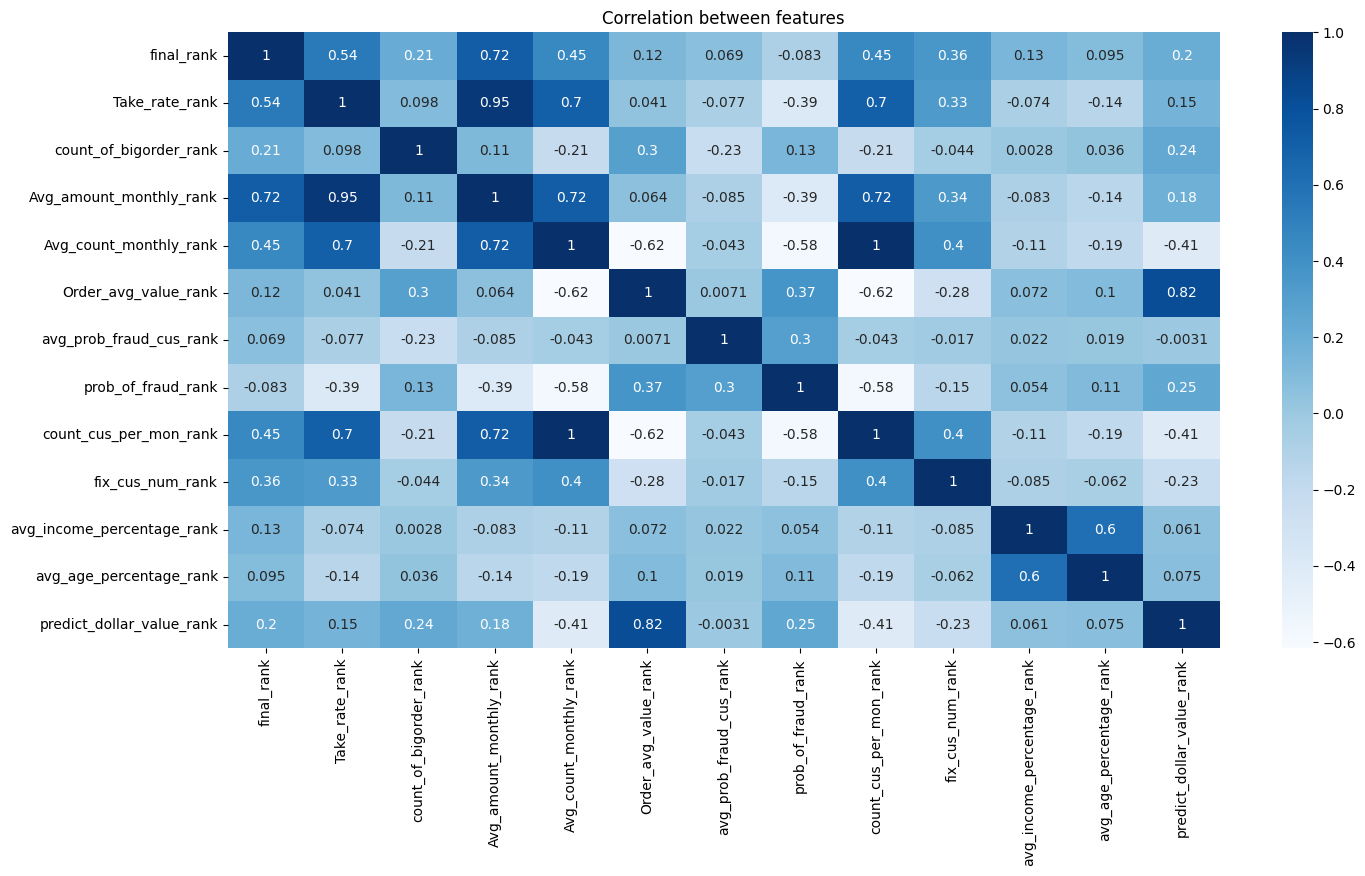

In [47]:
# Plot the heatmap to find the correlation
plt.figure(figsize=(16,8))
cor = compare_feature_rank_pic.corr()
heatmap = sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
heatmap.set_title('Correlation between features')
#plt.show()
plt.savefig('../plots/heatmap.jpg', bbox_inches='tight')

In [46]:
compare_feature_rank.to_parquet('../data/curated/compare_feature_rank.parquet')